# **Projeto Final - Noções de Inteligência Artificial 2025/1**
## **Alunos**:
- Caio Medeiros Balaniuk (matrícula: 231025190)
- Davi Henrique Vieira Lima (matrícula: 231013529)
- Gabriel Caixeta Romero (matrícula: 232036896)
- Vitor Amorim Mello (matrícula: 231037048)


# **1. Instalação da Biblioteca D2L**
A biblioteca `D2L` (**Dive Into Deep Learning**) é necessária ser instalada para permitir:
  *  Utilitários prontos para carregar e visualizar datasets como MNIST, Fashion-MNIST, entre outros.
  *  Funções auxiliares para construir, treinar e avaliar redes neurais em PyTorch.
  *  Classes úteis como `DataModule`, `Trainer`, `Classifier`, entre outras, que facilitam o desenvolvimento e experimentação com redes neurais.

In [1]:
!pip install d2l

# **2. Importação de Bibliotecas**
Para permitir o desenvolvimento do trabalho, é necessário a importação das seguintes bibliotecas:
  * `pandas`: principal biblioteca para **manipulação e análise de dados tabulares** (DataFrames).
  * `os`: biblioteca para **interagir com o sistema operacional**, útil para manipulação de arquivos e diretórios.
  * `gdown`: biblioteca utilizada para **fazer download de arquivos diretamente do Google Drive**, facilitando o carregamento de datasets.
  * `zipfile`: módulo padrão do Python para **descompactar arquivos .zip**, usado quando o dataset vem comprimido.
  * `torch`: principal biblioteca de **machine learning com PyTorch**.
  * `torch from d2l`: apresenta utilitários da biblioteca **Dive into Deep Learning (d2l)** para PyTorch.
  * `nn from torch`: módulo de **redes neurais (neural networks)** do PyTorch.
  * `train_test_split from sklearn.model_selection`: função para **dividir os dados em conjuntos de treino e teste**, importante para validação do modelo.
  * `StandardScaler from sklearn.preprocessing`: usada para **normalizar características numéricas**, garantindo que cada feature tenha média 0 e desvio padrão 1.
  * `matplotlib.pyplot`: permite a visualização gráfica do **Matplotlib**.

In [3]:
import pandas as pd
import os
import gdown
import zipfile
import torch
from d2l import torch as d2l
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# **3. Dataset**

## **3.1. Tabela FIPE**
O dataset utilizado neste trabalho é composto por dados extraídos da **Tabela Fipe**, que é uma referência oficial no Brasil para a **avaliação de preços médios de veículos automotores** (carros, motos e caminhões).

A **Tabela Fipe** é elaborada pela **Fundação Instituto de Pesquisas Econômicas (FIPE)** e fornece mensalmente o **preço médio praticado no mercado nacional para veículos novos e usados**.

Cada registro da Tabela Fipe geralmente contém informações como:
* **Marca do veículo** (ex: Fiat, Honda, Toyota),

* **Modelo do veículo** (ex: Palio 1.0, Civic EXL),

* **Ano de fabricação** (anomod),

* **Combustível utilizado** (ex: Gasolina, Flex, Diesel),

* **Mês/Ano de referência da cotação** (mesref / anoref),

* **Valor de mercado estimado** (em reais).

## **3.2. Extração e Organização do Dataset**
O conjunto de dados foi gerado utilizando um **web crawler** disponível no repositório [fipe-crawler](https://github.com/rafaelgou/fipe-crawler.git), que automatiza a coleta da Tabela Fipe diretamente do site oficial.

Foram coletadas informações dos **últimos 12 meses**, organizadas em múltiplos arquivos CSV (um para cada mês), contendo milhares de registros.

Esses arquivos foram agrupados em um **arquivo `.zip` hospedado no Google Drive**, sendo baixados e descompactados automaticamente pelo seguinte trecho de código:

In [4]:
# Baixar o arquivo zip do Google Drive
url = "https://drive.google.com/uc?id=125NtHsqQaokd76-ThXVmQLvLy1vXVd56"
output = "fipe_dataset.zip"
gdown.download(url, output, quiet=False)

# Descompactar
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("fipe_dataset_extracted")

# Caminho da pasta
caminho_pasta = "/content/fipe_dataset_extracted/dataset"


Downloading...
From: https://drive.google.com/uc?id=125NtHsqQaokd76-ThXVmQLvLy1vXVd56
To: /content/fipe_dataset.zip
100%|██████████| 187k/187k [00:00<00:00, 84.2MB/s]


## **3.3. Leitura e Pré-processamento Inicial dos Dados**

Nesta etapa, realizamos a leitura dos arquivos `.csv` extraídos do arquivo `.zip` contendo os dados mensais da Tabela Fipe.

Etapas do processo:

1. **Listagem dos Arquivos:** Todos os arquivos dentro do diretório da base são listados e ordenados alfabeticamente para garantir consistência na leitura.

2. **Leitura de Cada Arquivo CSV:** Cada arquivo `.csv` é lido individualmente utilizando o `pandas.read_csv`. Caso haja erro na leitura de algum arquivo (ex: linhas mal formatadas), ele será ignorado com a opção `on_bad_lines="skip"`.

3. **Concatenação dos Dados:** Todos os DataFrames lidos são concatenados em um único DataFrame chamado `dados`, unificando todos os registros coletados ao longo dos meses.

4. **Criação da Coluna `timeprod`:** Essa coluna representa o tempo de produção do veículo (em meses) desde seu ano de fabricação (`anomod`) até o ano e mês de referência (`anoref`, `mesref`).

5. **Seleção de Colunas Relevantes:** Apenas as colunas de interesse são mantidas para a análise: marca, modelo, ano de fabricação, tipo de combustível, tempo de produção e valor.

6. **Filtragem de Registros com Valores Realistas:** São removidos registros com anos ou tempos de produção considerados fora do intervalo aceitável (anomalias ou erros de coleta).

7. **Remoção de Duplicatas:** Garante que não haja linhas repetidas no conjunto final.

8. **Exibição Final:** Apresenta o DataFrame resultante com os dados prontos para o pré-processamento posterior e uso em modelos de aprendizado de máquina.



In [5]:
# Lista das marcas populares a serem mantidas
marcas_populares = [
    "Fiat", "VW - VolksWagen", "Chevrolet", "Ford", "Honda", "Renault",
    "Toyota", "Hyundai", "Jeep", "Citroën", "Nissan", "Mitsubishi", "Peugeot"
]

arquivos = sorted(os.listdir(caminho_pasta))

dfs = []

for arquivo in arquivos:
    caminho_arquivo = os.path.join(caminho_pasta, arquivo)
    try:
        df = pd.read_csv(caminho_arquivo, engine="python", on_bad_lines="skip")
        dfs.append(df)
    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

dados = pd.concat(dfs, ignore_index=True)

# Criação da coluna de tempo de produção (em meses)
dados["timeprod"] = (dados["anoref"] - dados["anomod"]) * 12 + (dados["mesref"] - 1)

# Seleção das colunas relevantes
dados_final = dados[["marca", "modelo", "anomod", "comb", "timeprod", "valor"]]

# Filtro por ano e tempo de produção plausíveis
dados_filtrados = dados_final[
    (dados_final["anomod"] >= 1980) & (dados_final["anomod"] <= 2025) &
    (dados_final["timeprod"] >= 0) & (dados_final["timeprod"] <= 600)
]

# Filtro pelas marcas populares
dados_filtrados = dados_filtrados[dados_filtrados["marca"].isin(marcas_populares)]

# Remoção de duplicatas
dt = dados_filtrados.drop_duplicates()

print(dt)


                marca                                    modelo  anomod  \
51            Citroën  AIRCROSS Exc. ATACA. 1.6 Flex 16V 5p Mec    2014   
52            Citroën   AIRCROSS Exclusive 1.6 Flex 16V 5p Aut.    2012   
53            Citroën        AIRCROSS Live 1.6 Flex 16V 5p Mec.    2018   
54            Citroën   AIRCROSS SALOMON TENDANCE 1.6 Flex Aut.    2015   
55            Citroën   Berlingo MultSpace GLX 1.6 16V 110cv 4p    2005   
...               ...                                       ...     ...   
9347  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2013   
9348  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2012   
9349  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2011   
9350  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2010   
9351  VW - VolksWagen      VOYAGE TREND 1.6 Mi Total Flex 8V 4p    2009   

          comb  timeprod  valor  
51    Gasolina       129  38378  
52    Gasolina       153  35021

## **3.4. Preparação dos Dados para Treinamento**

Nesta etapa, os dados brutos são processados e preparados para alimentar o modelo de regressão. O processo envolve:

1. **Limpeza Inicial dos Dados**  
   - Remoção de registros incompletos
   - Separação entre features (variáveis preditoras) e target (valor a ser previsto)

2. **Divisão dos Dados**  
   - Separação em conjuntos de treino (80%) e teste (20%)
   - Garantia de reprodutibilidade através de seed fixa

3. **Transformação das Variáveis**  
   - Categóricas: convertidas para formato numérico via codificação
   - Numéricas: normalizadas para mesma escala
   - Aplicação consistente das transformações em treino e teste

4. **Conversão para Tensores**  
   ```python
   # Exemplo básico de conversão
   dados_treino = torch.tensor(valores, dtype=torch.float32)
   ```
   - Adequação ao formato esperado pelo PyTorch
   - Ajuste das dimensões dos tensores

5. **Verificação Final**
   - Confirmação das dimensões dos dados
   - Validação dos tipos de dados

Todo o pipeline garante que os dados estejam devidamente estruturados e normalizados antes do treinamento do modelo.

In [6]:
# 1. Separar features (X) e alvo (y)
df = dt.dropna()
X = df.drop('valor', axis=1)
y = df['valor']

# 2. Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Pré-processamento dos dados
categorical_features = ['marca', 'modelo', 'comb']
numerical_features = ['anomod', 'timeprod']

# --- Processando os dados de TREINO ---
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_features])
X_train_numerical = pd.DataFrame(X_train_numerical_scaled, columns=numerical_features, index=X_train.index)
X_train_categorical = pd.get_dummies(X_train[categorical_features], drop_first=True)
X_train_processed = pd.concat([X_train_numerical, X_train_categorical], axis=1)

# --- Processando os dados de TESTE ---
X_test_numerical_scaled = scaler.transform(X_test[numerical_features])
X_test_numerical = pd.DataFrame(X_test_numerical_scaled, columns=numerical_features, index=X_test.index)
X_test_categorical = pd.get_dummies(X_test[categorical_features], drop_first=True)
X_test_processed = pd.concat([X_test_numerical, X_test_categorical], axis=1)


X_test_processed = X_test_processed.reindex(columns=X_train_processed.columns, fill_value=0)

# 4. Conversão para Tensores PyTorch

# FORÇA a conversão de todos os dados para float32 ANTES de criar o tensor.
# Isso resolve o problema de conversão do NumPy.
# Usamos .to_numpy() que é a forma moderna e recomendada no lugar de .values
X_train_tensor = torch.tensor(X_train_processed.astype('float32').to_numpy())
y_train_tensor = torch.tensor(y_train.astype('float32').to_numpy()).view(-1, 1)

X_test_tensor = torch.tensor(X_test_processed.astype('float32').to_numpy())
y_test_tensor = torch.tensor(y_test.astype('float32').to_numpy()).view(-1, 1)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([3568, 1675])
torch.Size([3568, 1])
torch.Size([893, 1675])
torch.Size([893, 1])


# **4. Modelos**

**Regressão Linear**

Implementação do Modelo

In [7]:
class LinearRegression(d2l.Module):
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

In [8]:
@d2l.add_to_class(LinearRegression)
def forward(self, X):
    return self.net(X)

In [9]:
@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    mse = nn.MSELoss()(y_hat, y)
    l2 = 0.001 * torch.sum(self.net.weight.data ** 2)  # λ = 0.001
    return mse + l2

In [10]:
@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

Treino

In [11]:
#instanciando o modelo
from d2l import torch as d2l

# Cria o modelo com taxa de aprendizado (por exemplo, 0.03)
model = LinearRegression(lr=0.03)

# Inicializa o trainer da D2L (gerencia o loop de treino)
trainer = d2l.Trainer(max_epochs=80)

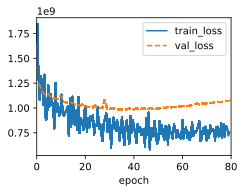

In [12]:
#treinando o modelo
# Prepara o conjunto de dados como TensorDataset
from torch.utils.data import TensorDataset, DataLoader
from d2l import torch as d2l

# Conjunto de treino e teste
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor) # Create test dataset as well

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16) # Create test loader

# Create a DataModule
class DataModule(d2l.DataModule):
    def __init__(self, train_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = test_loader # Use test_loader as validation loader for this example

    def get_dataloader(self, train):
        if train:
            return self.train_loader
        else:
            return self.val_loader

data = DataModule(train_loader, test_loader)

# Treinamento
trainer.fit(model, data)

Avaliação

In [13]:
import torch.nn.functional as F

# Avaliação no conjunto de teste
model.eval()  # Coloca o modelo em modo de avaliação
predictions = []
targets = []

with torch.no_grad():  # Desliga o cálculo de gradiente para avaliação
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        predictions.append(y_pred)
        targets.append(y_batch)

# Concatena todos os resultados
preds = torch.cat(predictions, dim=0)
targets = torch.cat(targets, dim=0)

# Calcula o MSE e RMSE
mse = F.mse_loss(preds, targets).item()
rmse = mse ** 0.5

# Calcula o MAE
mae = F.l1_loss(preds, targets).item()

print(f"RMSE (erro quadrático médio raiz): {rmse:.2f}")
print(f"MAE (erro absoluto médio): {mae:.2f}")


RMSE (erro quadrático médio raiz): 26617.28
MAE (erro absoluto médio): 14446.70


Visualização

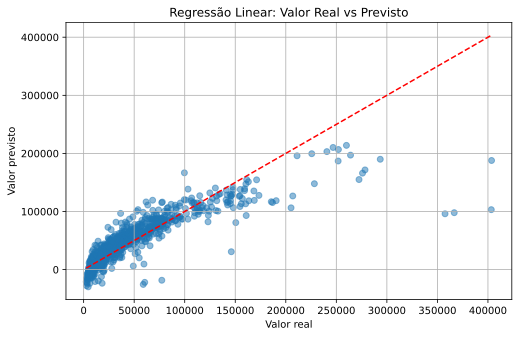

In [14]:
#comparar visualmente o valor real com a previsão:
import matplotlib.pyplot as plt

# Converte tensores para numpy
y_true = y_test_tensor.view(-1).detach().numpy()
# Collect all predictions from the test set
all_predictions = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_batch = model(X_batch)
        all_predictions.append(y_pred_batch)

y_pred_np = torch.cat(all_predictions, dim=0).view(-1).detach().numpy()


# Gráfico de dispersão
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred_np, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Valor previsto")
plt.title("Regressão Linear: Valor Real vs Previsto")
plt.grid(True)
plt.show()

**Modelo MLP**

Implementação do Modelo

In [29]:
# Aplica log1p para evitar problemas com valores zero
y_train_log_tensor = torch.log1p(y_train_tensor)
y_test_log_tensor = torch.log1p(y_test_tensor)

class MLPRegressor(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Linear(X_train_tensor.shape[1], 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def loss(self, y_hat, y):
        return nn.MSELoss()(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

    def forward(self, X):
        return self.net(X)

Treino

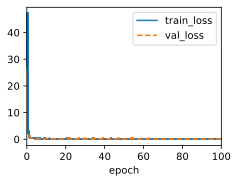

In [30]:
model_mlp = MLPRegressor(lr=0.05)
trainer_mlp = d2l.Trainer(max_epochs=100)

train_dataset = TensorDataset(X_train_tensor, y_train_log_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_log_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

class DataModule(pl.LightningDataModule):
    def __init__(self, train_loader, test_loader):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = test_loader  # using test as val

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader


data_module = DataModule(train_loader, test_loader)

trainer_mlp.fit(model_mlp, data_module)

Predição e inversão da escala (exponencial)

In [31]:
# Faz a predição e aplica inversa do log1p
y_pred_log = model_mlp(X_test_tensor)
y_pred_real = torch.expm1(y_pred_log)  # expm1 desfaz o log1p

Avaliação (MSE real)

In [32]:
# Importar a função MAE
from sklearn.metrics import mean_absolute_error

mse = nn.MSELoss()(y_pred_real, y_test_tensor).item()
print(f"MSE (MLP com log): {mse:.2f}")

# Converter para numpy
y_true = y_test_tensor.view(-1).detach().cpu().numpy()
y_pred = y_pred_real.view(-1).detach().cpu().numpy()

# Calcular RMSE e MAE
rmse = mse ** 0.5
mae = mean_absolute_error(y_true, y_pred)

# Imprimir os resultados
print(f"RMSE (MLP com log): {rmse:.2f}")
print(f"MAE (MLP com log): {mae:.2f}")

MSE (MLP com log): 471480704.00
RMSE (MLP com log): 21713.61
MAE (MLP com log): 7957.41


Visualização

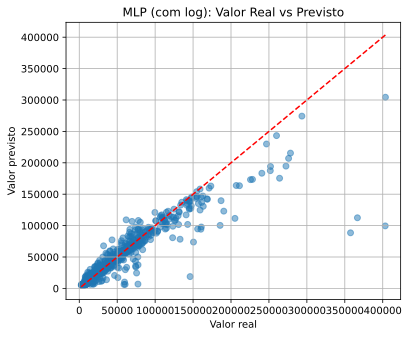

In [33]:
y_true = y_test_tensor.view(-1).detach().numpy()
y_pred = y_pred_real.view(-1).detach().numpy()

plt.figure(figsize=(6, 5))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('Valor real')
plt.ylabel('Valor previsto')
plt.title('MLP (com log): Valor Real vs Previsto')
plt.grid(True)
plt.show()

# **Calcular o R² Score para MLP com log**

In [34]:
from sklearn.metrics import r2_score

r2_log = r2_score(y_true, y_pred_np)
print(f"R² Score (MLP com log): {r2_log:.4f}")

R² Score (MLP com log): 0.7273


### Interpretação do R² Score

O R² (coeficiente de determinação) avalia o quão bem o modelo explica a variação dos dados:

- R² = 1.0 → predição perfeita
- R² = 0.0 → modelo não tem utilidade (igual à média)
- R² < 0.0 → modelo pior que a média
- R² entre 0.6 e 0.8 → modelo razoável
- R² > 0.8 → modelo excelente
